In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import uniform_filter, gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import binned_statistic
# from python files, functions I have made myself
from extract_transect import extract_transect
from filter_1D_profile_and_unwrap import unwrap_1D
%matplotlib  widget

<class 'numpy.complex64'>
(3600, 18000)


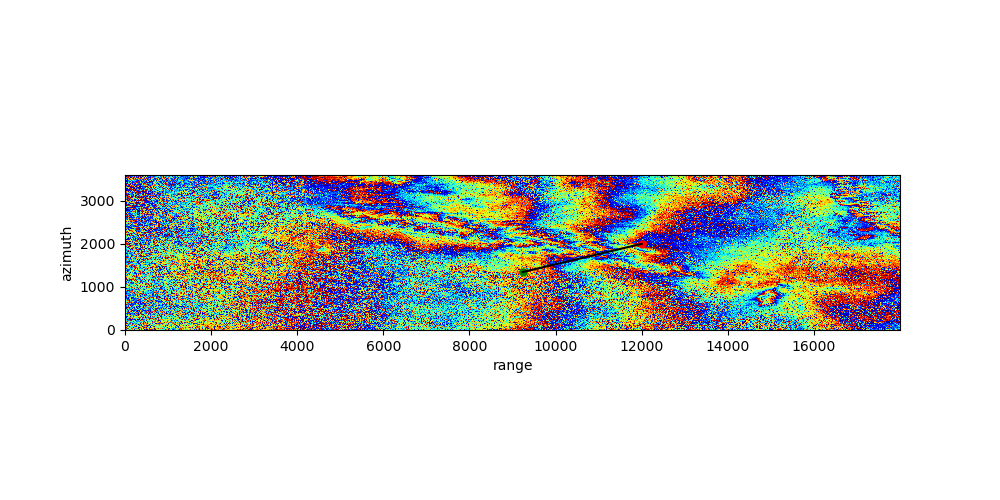

In [2]:
# set up an igram to use as the data array to input to function 
workdir = '/data/ocp4/LagunaSalada/'
cropdir='cropped_9000_1800_18000_3600/'
date1='20190711'
date2='20190723'
x0=0; dx=18000; y0=0; dy=3600 # changes with different subregion
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", \
               gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", \
               gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
int12 = slc1 * np.conj(slc2)
print(type(int12[0,0]))
print(np.shape(int12))
# define the points you want the transect to be between
testStart = [9234, 1345]
testEnd = [12000, 2000]

# plot the full igram and the transect I want to extract
plt.figure(figsize=(10, 5))
plt.imshow(np.angle(int12),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
     interpolation='nearest',origin='lower')
plt.plot(testStart[0],testStart[1],'g.',markersize=10)
plt.plot(testEnd[0],testEnd[1],'r.',markersize=10)
plt.plot((testStart[0],testEnd[0]),(testStart[1],testEnd[1]),'k-',markersize=10)
#plt.xlim([testStart[0], testEnd[0]])
#plt.ylim([testStart[1], testEnd[1]])
#plt.xlim([8000, 14000])
#plt.ylim([1000,2500])
plt.ylabel('azimuth'); plt.xlabel('range')
plt.show()

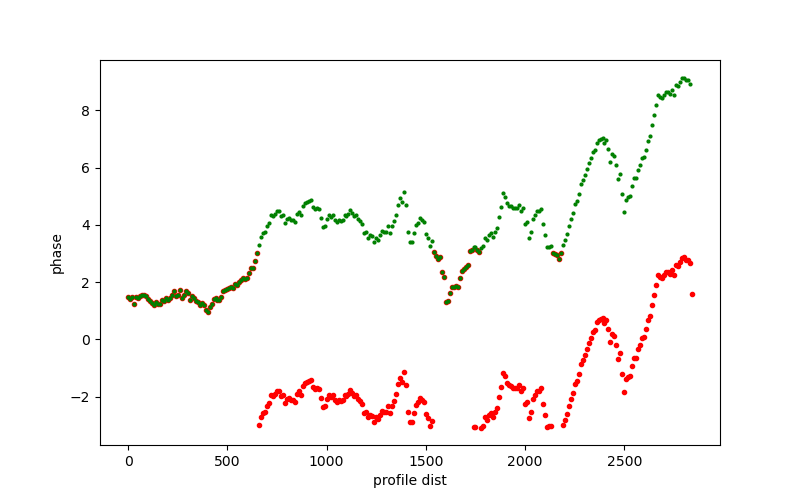

In [3]:
#print(np.shape(int12))

testResults = extract_transect(int12, testStart, testEnd, 5, 10)
#print(np.shape(testResults))

# the following still doesn't work 
unwrapped = unwrap_1D(testResults, 4, np.pi/2)
#print(np.shape(unwrapped))
#print(unwrapped)

plt.figure(figsize=(8, 5))
plt.plot(np.real(testResults[0]),np.angle(testResults[1]),'r.',markersize=6)
plt.plot(np.real(unwrapped[0]),unwrapped[1],'g.',markersize=4)
plt.ylabel('phase'); plt.xlabel('profile dist')
plt.show()

In [47]:
# copy in the extract_transect.py code so I can edit it and test before changing the real thing

def extract_transect(data, start, end, perpDist, binSize):
    import numpy as np
    
    # make sure the start and end inputs are not the same point
    if end[0]==start[0] and end[1]==start[1]:
        print('Start and end points the same. Change one of them.')
        return
    
    # vertical transect 
    if end[0]==start[0]:
        # this is a vertical line, x coords are the same 
        xVal = start[0] 
        yVals = [start[1], end[1]]
        data1 = data[min(yVals):max(yVals),xVal-perpDist:xVal+perpDist]
        plt.figure(figsize=(5, 3))
        plt.imshow(np.angle(data1),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
                interpolation='nearest',origin='lower')
        plt.show()
        print('shape of extracted data rectangle: '+str(np.shape(data1)))
        # if the line goes from larger to smaller y vals, flip the array 
        dy = (end[1]-start[1])
        dx = 2*perpDist
        if dy < 0:
            data1 = np.flipud(data1)
            dy = np.abs(dy)
        # make sure it flipped in the correct direction
        plt.figure(figsize=(5, 3))
        plt.imshow(np.angle(data1),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
                interpolation='nearest',origin='lower')
        plt.colorbar()
        plt.show() 
        bins = np.arange(0,dy,binSize)
        numBins = np.shape(bins)[0]
        print('number of bins: '+str(numBins))
        print('last value in bins: '+str(bins[-1]))
        print('bins: '+str(bins))
        # ignore the very last bin, it doesn't contain the same amount of information as the other bins
        # it is just what is leftover after the last real bin 
        binnedVals=np.ndarray([numBins-1,1],'complex')
        #print('data1[0] = '+str(data1[0]))
        for i in np.arange(numBins-1):
            binLow = bins[i]
            binHigh = bins[i+1]
            print('binLow: '+str(binLow)+'   binHigh: '+str(binHigh))
            binnedVals[i] = np.mean(data1[binLow:binHigh-1,:]) 

        print('all binnedVals: ')
        print(binnedVals)
        # put bins and binnedVals together in an array to be the output of the function 
        # make the bins values in the output the midpoints of the bin intervals to accurately represent where the data is from
        bins0 = np.diff(bins)/2+bins[0:-1]
        # must reshape them first so that they are (1,n) dimensions
        bins1 = bins0.reshape((1,numBins-1))
        binnedVals1 = binnedVals.reshape((1,numBins-1))
        print('reshaped binned vals type: '+str(type(binnedVals1[0,0])))
        output = np.vstack((bins1,binnedVals1))
        print('output shape: '+str(np.shape(output)))
        return output

    # horizontal transect
    if end[1]==start[1]:
        # this is a horizontal line, y coords are the same 
        xVals = [start[0], end[0]]
        yVal = start[1]
        data1 = data[yVal-perpDist:yVal+perpDist,min(xVals):max(xVals)]
        plt.figure(figsize=(5, 3))
        plt.imshow(np.angle(data1),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
                interpolation='nearest',origin='lower')
        plt.show()
        print('shape of extracted data rectangle: '+str(np.shape(data1)))
        # if the line goes from larger to smaller x vals, flip the array 
        dy = 2*perpDist
        dx = (end[0]-start[0])
        if dx < 0:
            data1 = np.fliprl(data1)
            dx = np.abs(dx)
        # make sure it flipped in the correct direction
        plt.figure(figsize=(5, 3))
        plt.imshow(np.angle(data1),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
                interpolation='nearest',origin='lower')
        plt.colorbar()
        plt.show() 
        bins = np.arange(0,dx,binSize)
        numBins = np.shape(bins)[0]
        print('number of bins: '+str(numBins))
        print('last value in bins: '+str(bins[-1]))
        print('bins: '+str(bins))
        binnedVals=np.ndarray([numBins-1,1],'complex')
        #print('data1[0] = '+str(data1[0]))
        for i in np.arange(numBins-1):
            binLow = bins[i]
            binHigh = bins[i+1]
            print('binLow: '+str(binLow)+'   binHigh: '+str(binHigh))
            binnedVals[i]= np.mean(data1[:,binLow:binHigh-1]) 
        
        print('first few binnedVals: ')
        print(binnedVals[0:20])
        # put bins and binnedVals together in an array to be the output of the function 
        # make the bins values in the output the midpoints of the bin intervals to accurately represent where the data is from
        bins0 = np.diff(bins)/2+bins[0:-1]
        # must reshape them first so that they are (1,n) dimensions
        bins1 = bins0.reshape((1,numBins-1))
        binnedVals1 = binnedVals.reshape((1,numBins-1))
        print('reshaped binned vals type: '+str(type(binnedVals1[0,0])))
        output = np.vstack((bins1,binnedVals1))
        print('output shape: '+str(np.shape(output)))
        return output
    
    
    
    # plot the raw input data but only between the start and end points (the box that will be extracted)
    plt.figure(figsize=(5, 3))
    plt.imshow(np.angle(data), \
            vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
            interpolation='nearest',origin='lower')
    plt.xlim([min([start[0],end[0]]),max([start[0],end[0]])])
    plt.ylim([min([start[1],end[1]]),max([start[1],end[1]])])
    plt.show()
    
    dx = (end[0]-start[0])
    dy = (end[1]-start[1])

    theta = np.abs(np.arctan(dy/dx))
    print(str(theta*180/np.pi)+' degrees')
    # design rotation matrix 
    rot = np.zeros((2,2),'float')
    rot[0] = [np.cos(theta),np.sin(theta)]
    rot[1] = [-np.sin(theta),np.cos(theta)]
    print('rotation matrix: ')
    print(rot)
    
    # pull out the minimum x value, max x val, and the same for y vals
    xVals = [start[0], end[0]]
    yVals = [start[1], end[1]]
    print('x vals: '+str(xVals))
    print('y vals: '+str(yVals))
    print('data type of x/y vals: '+str(type(int(min(xVals)))))
    
    # pull out only the relevant box within the data array [rows(y), columns(x)]
    data1 = data[min(yVals):max(yVals),min(xVals):max(xVals)]
    print('data1: '+ str(np.shape(data1)))
    #print(data1[0]) 
    
    plt.figure(figsize=(5, 3))
    plt.imshow(np.angle(data1),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
            interpolation='nearest',origin='lower')
    plt.show()
    print('shape of extracted data rectangle: '+str(np.shape(data1)))
    
    # now flip the extracted box IF the line isn't in the up-to-the-right direction
    if dx < 0:
        print('flipping array horizontally')
        data1 = np.fliplr(data1)
        print('flipped data: \n'+str(type(data1))) 
        dx = np.abs(dx)
    print('dx = '+str(dx))
    # flip the array if y2 < y1 so that we are going from smaller to larger vals 
    if dy < 0:
        print('flipping array vertically')
        data1 = np.flipud(data1)
        print('flipped data: \n'+str(type(data1)))
        dy = np.abs(dy)
        print('new dy: '+str(type(dy)))
    print('dy = '+str(dy))
    print('data: \n'+str(type(data[0,0])))
    
    # make sure it flipped in the correct direction
    plt.figure(figsize=(5, 3))
    plt.imshow(np.angle(data1),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='equal', \
            interpolation='nearest',origin='lower')
    plt.show()
    
    
    # make a meshgrid for defining coordinates of the centers of pixels 
    x = np.arange(0,dx,1)
    y = np.arange(0,dy,1)
    grdx,grdy = np.meshgrid(x,y,indexing='xy')
    print('x shape: '+str(np.shape(x)))
    print('y shape: '+str(np.shape(y)))
    
    # reshape these to be x in first row, y in second row
    grdx1 = grdx.reshape(1,dx*dy)
    grdy1 = grdy.reshape(1,dx*dy)
    print('grdx1 shape: '+str(np.shape(grdx1)))
    print(grdx1[0:20])
    print('grdy1 shape: '+str(np.shape(grdy1)))
    print(grdy1[0:20])
    grd = np.vstack((grdx1,grdy1)) 
    
    plt.figure(figsize=(5, 3))
    plt.imshow(grdx, cmap='jet', aspect='equal', \
            interpolation='nearest',origin='lower')
    plt.show()
    print('grd shape: '+str(np.shape(grd)))
    newxy = np.matmul(rot,grd)
    print('newxy shape: '+str(np.shape(newxy)))
    
    #reshape again
    x1 = newxy[0,:].reshape((dy,dx)) # this is distance along transect
    y1 = newxy[1,:].reshape((dy,dx)) # this is distance perpendicular to transect
    print('new Xs: '+str(np.shape(x1)))
    #print(x1[0:20])
    print('new Ys: '+str(np.shape(y1)))
    #print(y1[0:20])
    print('max of x1: '+str(np.max(x1)))
    plt.figure(figsize=(5, 3))
    plt.imshow(y1, cmap='jet', aspect='equal',origin='lower')
    plt.show()
    
    # which points are within perpDist of the transect
    ind = np.where(np.abs(y1) < perpDist)
    print(ind)
    print('how many points within '+str(perpDist)+' of the transect?  '+str(np.shape(ind)[1]))
    # bin the data, can change bin width with last input into function
    TsctLength = np.sqrt(dx*dx+dy*dy)
    print('transect length: '+str(TsctLength))
    bins = np.arange(0,TsctLength,binSize)
    numBins = np.shape(bins)[0]
    print('number of bins: '+str(numBins))
    print('last value in bins: '+str(bins[-1]))
    print('bins: '+str(np.shape(bins)))
    dists = x1[ind]
    print('dists: '+str(np.shape(dists)))
    vals = data1[ind]
    print('vals: '+str(np.shape(vals)))
    binnedVals=np.ndarray([len(bins),1],'complex')
    print('binned vals: '+str(np.shape(binnedVals)))
    
    # find which values are in which bins and average them 
    for i in np.arange(len(bins)-1):
        inds = (np.where((dists >= bins[i]) & (dists < bins[i+1])))
        binnedVals[i]= np.mean(vals[inds]) 
    
    # MAKE SURE THAT binnedVals[-1] has something in it
    print('last 20 entries in binnedVals: '+str(binnedVals[-20:-1]))
    # yes, it does. 
    
    # put bins and binnedVals together in an array to be the output of the function 
    
    # make the bins values in the output the midpoints of the bin intervals to accurately represent where the data is from
    bins0 = np.diff(bins)/2+bins[0:-1]
    # must reshape them first so that they are (1,n) dimensions
    bins1 = bins0.reshape((1,numBins-1))
    binnedVals1 = binnedVals[0:-1].reshape((1,numBins-1))
    print('reshaped binned vals type: '+str(type(binnedVals1[0,0])))
    output = np.vstack((bins1,binnedVals1))
    print('output shape: '+str(np.shape(output)))
    #print('output[0] (=bins1 ?): ')
    #print(output[0].real)
    #print('output[1] (=binnedVals1 ?): ')
    #print(output[1])
    plt.figure(figsize=(8, 5))
    plt.plot(np.real(output[0]),np.angle(output[1]),'r.',markersize=4)
    plt.ylabel('phase'); plt.xlabel('profile dist')
    plt.show()
    # output is all complex so we have to take the real part of the bins = output[0] 
    # to plot it without having an issue with casting complex values
    return output

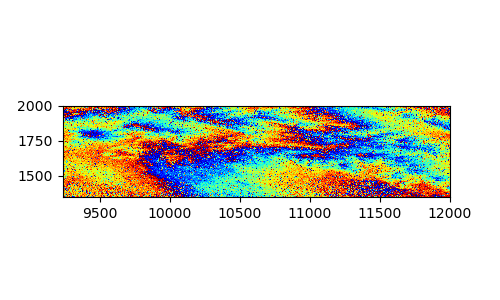

13.322466604917972 degrees
rotation matrix: 
[[ 0.97308859  0.23043132]
 [-0.23043132  0.97308859]]
x vals: [12000, 9234]
y vals: [1345, 2000]
data type of x/y vals: <class 'int'>
data1: (655, 2766)


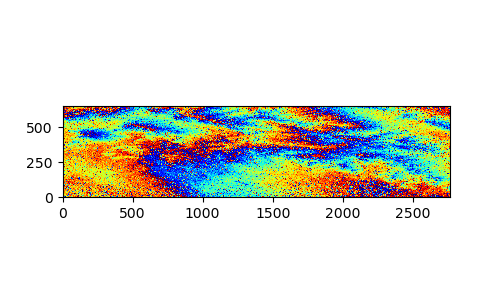

shape of extracted data rectangle: (655, 2766)
flipping array horizontally
flipped data: 
<class 'numpy.ndarray'>
dx = 2766
dy = 655
data: 
<class 'numpy.complex64'>


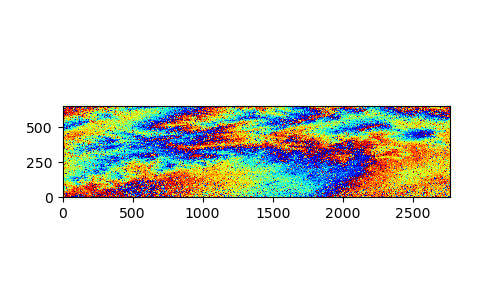

x shape: (2766,)
y shape: (655,)
grdx1 shape: (1, 1811730)
[[   0    1    2 ... 2763 2764 2765]]
grdy1 shape: (1, 1811730)
[[  0   0   0 ... 654 654 654]]


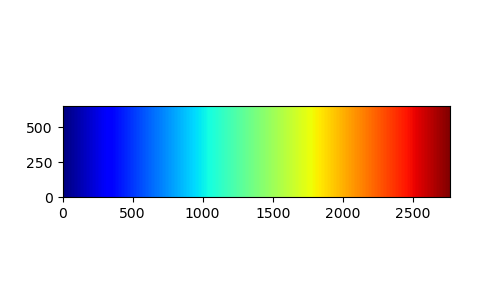

grd shape: (2, 1811730)
newxy shape: (2, 1811730)
new Xs: (655, 2766)
new Ys: (655, 2766)
max of x1: 2841.2920385733278


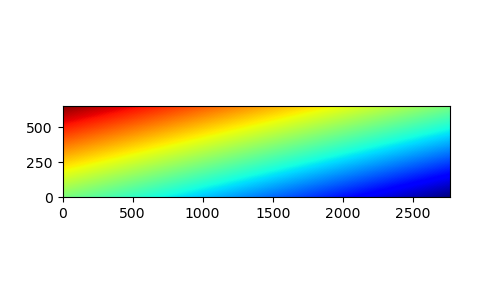

(array([  0,   0,   0, ..., 654, 654, 654]), array([   0,    1,    2, ..., 2763, 2764, 2765]))
how many points within 5 of the transect?  28313
transect length: 2842.495558483777
number of bins: 285
last value in bins: 2840.0
bins: (285,)
dists: (28313,)
vals: (28313,)
binned vals: (285, 1)
last 20 entries in binnedVals: [[-11337.19042969 -2788.05371094j]
 [ -9794.70117188  -327.06060791j]
 [ -8027.51464844  +822.79858398j]
 [ -4855.48583984 +1926.54089355j]
 [ -5606.08251953 +3708.13623047j]
 [-17496.75195312+11514.671875j  ]
 [ -9173.99023438 +4515.61132812j]
 [ -2564.90600586 +4369.20263672j]
 [  -846.40881348 +3249.51855469j]
 [  1200.14147949 +3684.01000977j]
 [  1429.78125    +3069.41235352j]
 [  2819.41992188 +2080.46459961j]
 [  4747.57714844 +8625.96191406j]
 [ 20374.48242188+95798.390625j  ]
 [    23.23586464 +2284.79931641j]
 [   650.47717285 +4413.64306641j]
 [   939.13873291 +2801.41601562j]
 [   885.64599609 +2025.4810791j ]
 [  2214.36694336 +2922.58105469j]]
reshaped bi

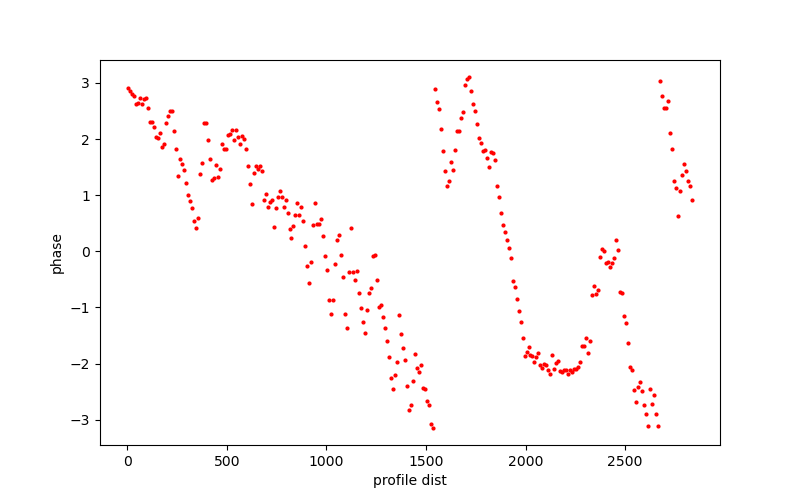

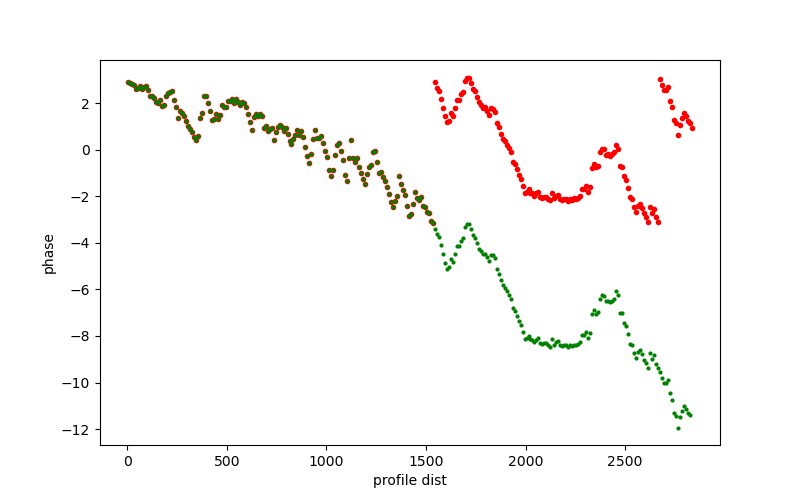

In [48]:
# define the points you want the transect to be between
# test 1
testStart1 = [9234, 1345]
testEnd1 = [12000, 2000]
# test 2
testStart2 = [12000, 2000]
testEnd2 = [9234, 1345]
# test 3
testStart3 = [9234, 2000]
testEnd3 = [12000, 1345]
# test 4
testStart4 = [12000, 1345]
testEnd4 = [9234, 2000]

# test 5 (vertical transect)
testStart5 = [9234, 2000]
testEnd5 = [9234, 1345]

# test 6 (horizontal transect)
testStart6 = [9234, 2000]
testEnd6 = [10000, 2000]


#print(np.shape(int12))
testResults = extract_transect(int12, testStart4, testEnd4, 5, 10)
#print(np.shape(testResults))

# the following still doesn't work 
unwrapped = unwrap_1D(testResults, 4, np.pi/2)
#print(np.shape(unwrapped))
#print(unwrapped)

plt.figure(figsize=(8, 5))
plt.plot(np.real(testResults[0]),np.angle(testResults[1]),'r.',markersize=6)
plt.plot(np.real(unwrapped[0]),unwrapped[1],'g.',markersize=4)
plt.ylabel('phase'); plt.xlabel('profile dist')
plt.show()

In [6]:
# test the built-in flipping commands 
matrix = [[2,3,4,5],[11,12,13,14],[22,23,24,25]]
print('matrix: \n'+str(matrix))
#print(np.shape(matrix))

matrix1 = np.flip(matrix)
print('Flipped: \n'+str(matrix1))

matrix2 = np.flipud(matrix)
print('Flipped up-down: \n'+str(matrix2))
#print(np.shape(matrix2))

matrix3 = np.fliplr(matrix)
print('Flipped left-right: \n'+str(matrix3))
#print(np.shape(matrix3))

matrix: 
[[2, 3, 4, 5], [11, 12, 13, 14], [22, 23, 24, 25]]
Flipped: 
[[25 24 23 22]
 [14 13 12 11]
 [ 5  4  3  2]]
Flipped up-down: 
[[22 23 24 25]
 [11 12 13 14]
 [ 2  3  4  5]]
Flipped left-right: 
[[ 5  4  3  2]
 [14 13 12 11]
 [25 24 23 22]]


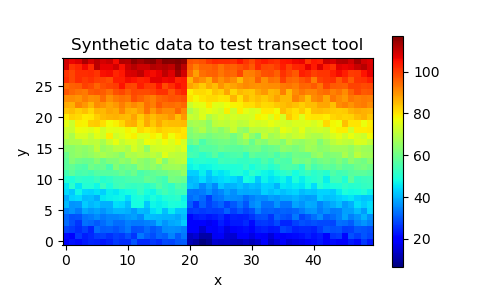

In [49]:
# Test transect tool with synthetic data!! 

# make some synthetic data 
x = np.arange(0,50,1)
y = np.arange(0,30,1)
grdx,grdy = np.meshgrid(x,y,indexing='xy')
dataSynth = 0.5*grdx+3*grdy
dataSynth[:,0:20] = dataSynth[:,0:20]+20
# now add noise 
noise=np.random.randn(30,50)*2
dataSynthNoise = dataSynth + noise

plt.figure(figsize=(5, 3))
plt.imshow(dataSynthNoise, cmap='jet', aspect='equal', \
        interpolation='nearest',origin='lower')
plt.xlabel('x'); plt.ylabel('y'); plt.colorbar()
plt.title('Synthetic data to test transect tool')
plt.show()

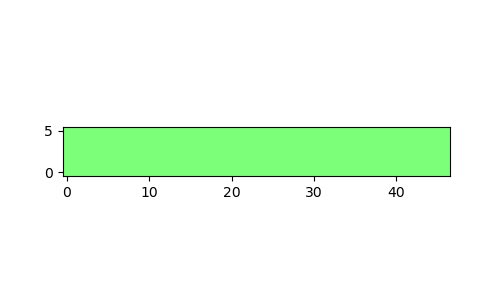

shape of extracted data rectangle: (6, 47)


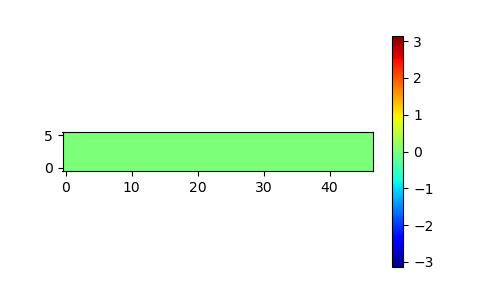

number of bins: 12
last value in bins: 44
bins: [ 0  4  8 12 16 20 24 28 32 36 40 44]
binLow: 0   binHigh: 4
binLow: 4   binHigh: 8
binLow: 8   binHigh: 12
binLow: 12   binHigh: 16
binLow: 16   binHigh: 20
binLow: 20   binHigh: 24
binLow: 24   binHigh: 28
binLow: 28   binHigh: 32
binLow: 32   binHigh: 36
binLow: 36   binHigh: 40
binLow: 40   binHigh: 44
first few binnedVals: 
[[79.54719293+0.j]
 [81.94889368+0.j]
 [83.87218825+0.j]
 [86.0878413 +0.j]
 [86.66374077+0.j]
 [69.63798186+0.j]
 [71.02352947+0.j]
 [72.86765188+0.j]
 [75.97100366+0.j]
 [77.10189843+0.j]
 [79.12310233+0.j]]
reshaped binned vals type: <class 'numpy.complex128'>
output shape: (2, 11)
<class 'numpy.complex128'>


In [52]:
# use the transect tool on it to test the transect tool 

# vertical 
startPt = [10, 0]
endPt = [10, 20]

# horizontal 
startPt = [1, 20]
endPt = [48, 20]

# diagonal 
#startPt = [0, 30]
#endPt = [50, 0]

test1 = extract_transect(dataSynthNoise, startPt, endPt, 3, 4)

print(type(test1[0,0]))

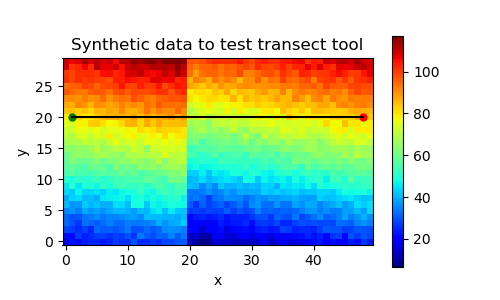

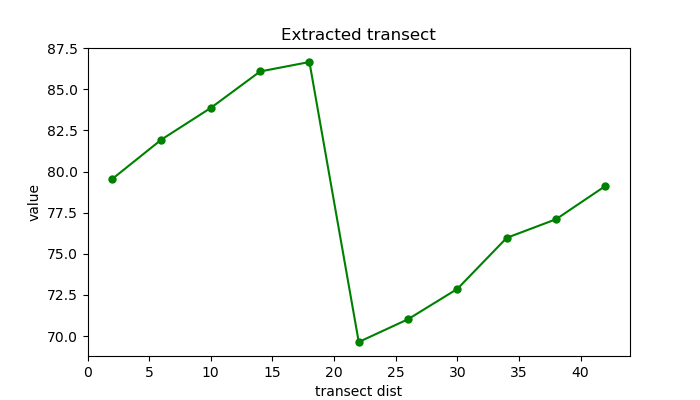

In [53]:
plt.figure(figsize=(5, 3))
plt.imshow(dataSynthNoise, cmap='jet', aspect='equal', \
        interpolation='nearest',origin='lower')
plt.plot(startPt[0],startPt[1],'g.',markersize=10)
plt.plot(endPt[0],endPt[1],'r.',markersize=10)
plt.plot((startPt[0],endPt[0]),(startPt[1],endPt[1]),'k-',markersize=10)
plt.xlabel('x'); plt.ylabel('y'); plt.colorbar()
plt.title('Synthetic data to test transect tool')
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(np.real(test1[0]),np.real(test1[1]),'g.-',markersize=10)
plt.xlabel('transect dist'); plt.ylabel('value')
plt.title('Extracted transect')
plt.show()

In [49]:
length1 = np.sqrt(30*30+50*50)
print('length of transect: '+str(length1))

length of transect: 58.309518948453004
